<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/BigGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Dense, Input, LeakyReLU, Reshape, Conv2D, Dense, Embedding
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)

Tensorflow 2.6.0


In [2]:
ds_train,  ds_info = tfds.load('cifar10', split='train', 
                                         as_supervised=True, shuffle_files=True, with_info=True)

In [3]:
IMAGE_HEIGHT = IMAGE_WIDTH = 32
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
BATCH_SIZE = 32
BUFFER_SIZE = 200

def preprocess(image, label):

    # normalize
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    
    label = tf.cast(label, tf.int32)
    return image, label

train_dataset = ds_train.map(preprocess, 
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [4]:
class SpectralNorm(tf.keras.constraints.Constraint):
    def __init__(self, n_iter=5):
        self.n_iter = n_iter

    def call(self, input_weights):
        w = tf.reshape(input_weights, (-1, input_weights.shape[-1]))
        u = tf.random.normal((w.shape[0], 1))
        for _ in range(self.n_iter):
            v = tf.matmul(w, u, transpose_a=True)
            v /= tf.norm(v)
            
            u = tf.matmul(w, v)
            u /= tf.norm(u)
            
        spec_norm = tf.matmul(u, tf.matmul(w, v), transpose_a=True)
        return input_weights/spec_norm

In [5]:
class OrthogonalReguralizer(tf.keras.regularizers.Regularizer):
    def __init__(self, beta=1e-4):
        self.beta = beta
        
    def __call__(self, input_tensor):
        c = input_tensor.shape[-1]
        x = tf.reshape(input_tensor, (-1, c))
        
        ortho_loss = tf.matmul(x, x, transpose_a=True) * (1 -tf.eye(c))
        return self.beta * tf.norm(ortho_loss)

    def get_config(self):
        return {'beta': self.beta}

In [6]:
g_kernel_cfg={
    'kernel_initializer' : tf.keras.initializers.Orthogonal,
    'kernel_constraint' : SpectralNorm(),
    'kernel_regularizer' : OrthogonalReguralizer()
}

d_kernel_cfg={
    'kernel_initializer' : tf.keras.initializers.Orthogonal,
    'kernel_constraint' : SpectralNorm(),
}

In [7]:
class SelfAttention(Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()
    
    def build(self, input_shape):
        n, h, w, c = input_shape
        self.n_feats = h * w
        self.conv_theta = Conv2D(c//8, 1, padding='same', **g_kernel_cfg,  name='Conv_Theta')
        self.conv_phi = Conv2D(c//8, 1, padding='same', **g_kernel_cfg, name='Conv_Phi')
        self.conv_g = Conv2D(c//2, 1, padding='same', **g_kernel_cfg, name='Conv_G')
        self.conv_attn_g = Conv2D(c, 1, padding='same', **g_kernel_cfg, name='Conv_AttnG')
        self.sigma = self.add_weight(shape=[1],
                                initializer='zeros',
                                trainable=True, name='sigma')
        
        
    def call(self, x):
        n, h, w, c = x.shape
        theta = self.conv_theta(x)
        theta = tf.reshape(theta, (-1, self.n_feats, theta.shape[-1]))
        
        phi = self.conv_phi(x)
        phi = tf.nn.max_pool2d(phi, ksize=2, strides=2, padding='VALID')
        phi = tf.reshape(phi, (-1, self.n_feats//4, phi.shape[-1]))
        
        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = tf.nn.softmax(attn)

        g = self.conv_g(x)
        g = tf.nn.max_pool2d(g, ksize=2, strides=2, padding='VALID')
        g = tf.reshape(g, (-1, self.n_feats//4, g.shape[-1]))

        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, (-1, h, w, attn_g.shape[-1]))
        attn_g = self.conv_attn_g(attn_g)
        
        output = x + self.sigma * attn_g
        
        return output

In [8]:
class ConditionBatchNorm(Layer):
    def __init__(self, decay_rate=0.999, eps=1e-4):
        super(ConditionBatchNorm, self).__init__()
        self.decay = decay_rate
        self.eps = 1e-5
        
    def build(self, input_shape):
        c = input_shape[-1]
        self.dense_beta = Dense(c, **g_kernel_cfg,)
        self.dense_gamma = Dense(c, **g_kernel_cfg,)
        self.moving_mean = self.add_weight(shape=[1, 1, 1, c], initializer='zeros',
                                          trainable=False, name='moving_mean')
    
        self.moving_var = self.add_weight(shape=[1, 1, 1, c], initializer='ones',
                                          trainable=False, name='moving_var')

    def call(self, x, z_y, training=False):
        beta = self.dense_beta(z_y)
        gamma = self.dense_gamma(z_y)
        for _ in range(2):
            beta = tf.expand_dims(beta, 1)
            gamma = tf.expand_dims(gamma, 1)
                
        if training:
            mean, var = tf.nn.moments(x, axes=(0,1,2), keepdims=True)
            self.moving_mean.assign(self.decay * self.moving_mean + (1-self.decay)*mean)
            self.moving_var.assign(self.decay * self.moving_var + (1-self.decay)*var)
            output = tf.nn.batch_normalization(x, mean, var, beta, gamma, self.eps)
 
        else:
            output = tf.nn.batch_normalization(x, 
                                               self.moving_mean, self.moving_var,
                                               beta, gamma, self.eps)

        return output

In [9]:
class Resblock(Layer):
    def __init__(self, filters, n_class):
        super(Resblock, self).__init__(name=f'g_resblock_{filters}x{filters}')
        self.filters = filters
        self.n_class = n_class
        
    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.conv_1 = Conv2D(self.filters, 3, padding='same', **g_kernel_cfg, name='conv2d_1')
        self.conv_2 = Conv2D(self.filters, 3, padding='same', **g_kernel_cfg, name='conv2d_2')
        self.cbn_1 = ConditionBatchNorm()
        self.cbn_2 = ConditionBatchNorm()
        self.learned_skip = False
        
        if self.filters != input_filter:
            self.learned_skip = True
            self.conv_3 = Conv2D(self.filters, 1, padding='same', **g_kernel_cfg, name='conv2d_3')
            self.cbn_3 = ConditionBatchNorm()
        
    def call(self, input_tensor, features):
        x = self.conv_1(input_tensor)
        x = self.cbn_1(x, features) #Pass in the concatenated [1/4 of z, embed(label)] for style
        x = tf.nn.leaky_relu(x, 0.2)
        
        x = self.conv_2(x)
        x = self.cbn_2(x, features) 
        x = tf.nn.leaky_relu(x, 0.2)
                
        if self.learned_skip:
            skip = self.conv_3(input_tensor)
            skip = self.cbn_3(skip, features) 
            skip = tf.nn.leaky_relu(skip, 0.2)            
        else:
            skip = input_tensor
            
        output = skip + x

        return output

In [10]:
def build_generator(z_dim, n_class, y_dim):

    DIM = 64
    
    z_input = layers.Input(shape=(z_dim))
    labels = layers.Input(shape=(1), dtype='int32')

    z = tf.split(z_input, 4, axis=1)

    y = Embedding(n_class, y_dim)(tf.squeeze(labels, [1]))

    x = Dense(4*4*4*DIM, **g_kernel_cfg)(z[0])
    x = layers.Reshape((4, 4, 4*DIM))(x)
    
    x = layers.UpSampling2D((2,2))(x)
    y_z = tf.concat((y, z[1]), axis=-1)
    x = Resblock(4*DIM, n_class)(x, y_z)
    
    x = layers.UpSampling2D((2,2))(x)
    y_z = tf.concat((y, z[2]), axis=-1)
    x = Resblock(2*DIM, n_class)(x, y_z)
    
    x = SelfAttention()(x)

    x = layers.UpSampling2D((2,2))(x)
    y_z = tf.concat((y, z[3]), axis=-1)
    x = Resblock(DIM, n_class)(x, y_z)
    
    output_image = tanh(Conv2D(3, 3, padding='same')(x))

    return Model([z_input, labels], 
                 output_image, 
                 name='generator')

In [11]:
class ResblockDown(Layer):
    def __init__(self, filters, downsample=True):
        super(ResblockDown, self).__init__()
        self.filters = filters
        self.downsample = downsample
        
    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.conv_1 = Conv2D(self.filters, 3, padding='same', **d_kernel_cfg)
        self.conv_2 = Conv2D(self.filters, 3, padding='same', **d_kernel_cfg)
        self.learned_skip = False
        
        if self.filters != input_filter:
            self.learned_skip = True
            self.conv_3 = Conv2D(self.filters, 1, padding='same', **d_kernel_cfg)        

    def down(self, x):
        return tf.nn.avg_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
            
    def call(self, input_tensor):
        x = self.conv_1(input_tensor)
        x = tf.nn.leaky_relu(x, 0.2)

        x = self.conv_2(x)
        x = tf.nn.leaky_relu(x, 0.2)

        if self.downsample:
            x = self.down(x)
            
        if self.learned_skip:
            skip = self.conv_3(input_tensor)
            skip = tf.nn.leaky_relu(skip, 0.2)            
            if self.downsample:
                skip = self.down(skip)
        else:
            skip = input_tensor
        output = skip + x
        return output

In [12]:
def build_discriminator(n_class):
    DIM = 64
    input_image = Input(shape=IMAGE_SHAPE)
    input_labels = Input(shape=(1))

    embedding = Embedding(n_class, 4*DIM)(input_labels)

    embedding = Flatten()(embedding)

    x = ResblockDown(DIM)(input_image) # 64
    
    x = ResblockDown(2*DIM)(x) # 32
    
    x = SelfAttention()(x)
    
    x = ResblockDown(4*DIM)(x) # 16
    
    x = ResblockDown(4*DIM, False)(x) # 4
    
    x = tf.reduce_sum(x, (1, 2))

    embedded_x  = tf.reduce_sum(x * embedding, axis=1,  keepdims=True)

    output = Dense(1)(x)
    
    output += embedded_x
    
    return Model([input_image, input_labels], output, name='discriminator')

In [13]:
class BigGAN(Model):

    def __init__(self, n_classes, z_dim=128, y_dim=32):
        super(BigGAN, self).__init__()
        self.z_dim = z_dim
        self.n_classes = n_classes

        self.generator = build_generator(z_dim, n_classes, y_dim)
        self.discriminator = build_discriminator(n_classes)

    def hinge_loss_d(self, y, is_real):
        label = 1. if is_real else -1.
        loss = self.hinge_loss(y, label)
        return loss
    
    def hinge_loss_g(self, y):
        return -tf.reduce_mean(y)
    
    def compile(self):
        self.hinge_loss = tf.keras.losses.Hinge()
        self.g_optimizer = Adam(1e-4, 0.0, 0.9)
        self.d_optimizer = Adam(4e-4, 0.0, 0.9)
        super(BigGAN, self).compile()
    
    def train_step(self, inputs):
        real_images, real_labels = inputs
        z = tf.random.normal((BATCH_SIZE, self.z_dim))
        fake_labels = real_labels

        with tf.GradientTape() as g_tape, \
            tf.GradientTape() as d_tape:
            
            fake_images = self.generator([z, fake_labels])
            
            fake_pred = self.discriminator([fake_images, fake_labels])
            real_pred = self.discriminator([real_images, real_labels])

            d_loss = 0.5 * (self.hinge_loss_d(fake_pred, False) + self.hinge_loss_d(real_pred, True))
            g_loss = self.hinge_loss_g(fake_pred)
        
        g_vars = self.generator.trainable_variables
        d_vars = self.discriminator.trainable_variables

        g_grads = g_tape.gradient(g_loss, g_vars)
        d_grads = d_tape.gradient(d_loss, d_vars)

        self.g_optimizer.apply_gradients(zip(g_grads, g_vars))
        self.g_optimizer.apply_gradients(zip(d_grads, d_vars))

        return {'g_loss': g_loss, 'd_loss': d_loss}
    
    def call(self, inputs):
        num_imgs, labels = inputs
        z = tf.random.normal((num_imgs, self.z_dim))
        return self.generator([z, labels])

In [14]:
class GenerativeCallback(tf.keras.callbacks.Callback):

    def __init__(self, interval=5):
        super(GenerativeCallback, self).__init__()
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            return 
        grid_row = 1
        grid_col = 10
        images = self.model([10, tf.convert_to_tensor(np.array([i for i in range(10)]))])
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col]+1)/2)
            axarr[col].axis('off') 
        plt.show()

Epoch 1/50
1562/1562 [==============================] - 92s 54ms/step - g_loss: 3.2937 - d_loss: 0.0513
Epoch 2/50
1562/1562 [==============================] - 79s 51ms/step - g_loss: 3.3459 - d_loss: 0.0148


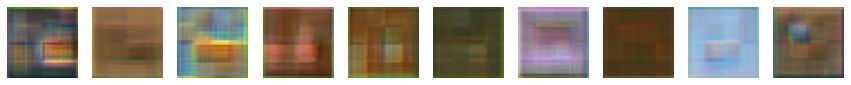

Epoch 3/50
1562/1562 [==============================] - 82s 52ms/step - g_loss: 2.8960 - d_loss: 0.0533


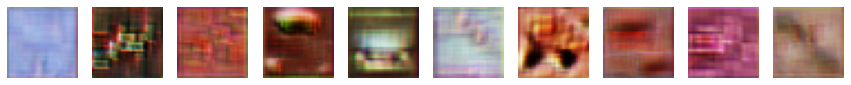

Epoch 4/50
1562/1562 [==============================] - 83s 53ms/step - g_loss: 2.6047 - d_loss: 0.1086
Epoch 5/50
1562/1562 [==============================] - 82s 53ms/step - g_loss: 2.5313 - d_loss: 0.1349


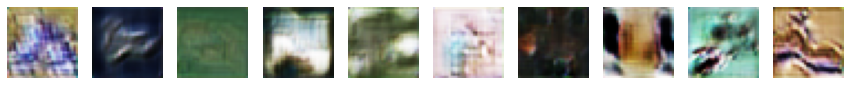

Epoch 6/50
1562/1562 [==============================] - 84s 54ms/step - g_loss: 2.3973 - d_loss: 0.1681


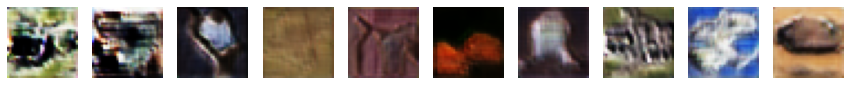

Epoch 7/50
1562/1562 [==============================] - 86s 55ms/step - g_loss: 2.3234 - d_loss: 0.1831
Epoch 8/50
1562/1562 [==============================] - 85s 54ms/step - g_loss: 2.2932 - d_loss: 0.1881


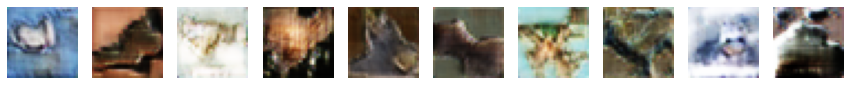

Epoch 9/50
1562/1562 [==============================] - 87s 56ms/step - g_loss: 2.2966 - d_loss: 0.1874


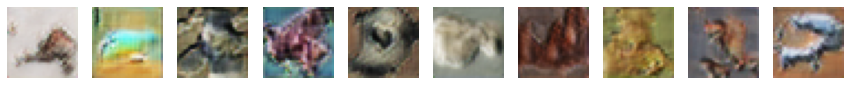

Epoch 10/50
1562/1562 [==============================] - 88s 56ms/step - g_loss: 2.3764 - d_loss: 0.1802
Epoch 11/50
1562/1562 [==============================] - 87s 56ms/step - g_loss: 2.4272 - d_loss: 0.1750


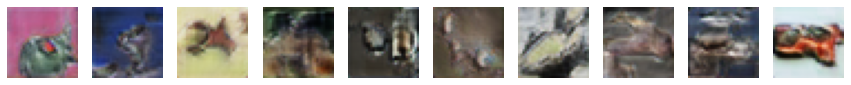

Epoch 12/50
1562/1562 [==============================] - 87s 56ms/step - g_loss: 2.4782 - d_loss: 0.1757


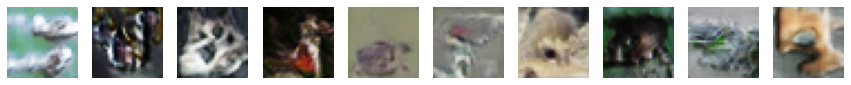

Epoch 13/50
1562/1562 [==============================] - 88s 56ms/step - g_loss: 2.5091 - d_loss: 0.1739
Epoch 14/50
1562/1562 [==============================] - 88s 56ms/step - g_loss: 2.5025 - d_loss: 0.1754


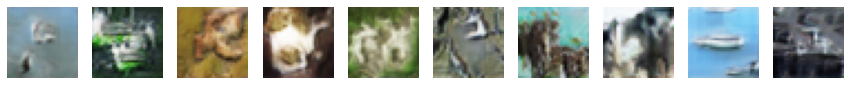

Epoch 15/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 2.5580 - d_loss: 0.1664


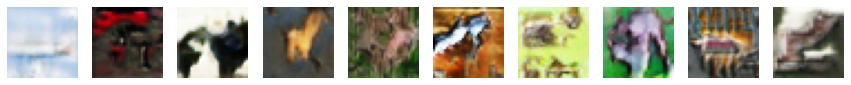

Epoch 16/50
1562/1562 [==============================] - 90s 58ms/step - g_loss: 2.5874 - d_loss: 0.1675
Epoch 17/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 2.6563 - d_loss: 0.1644


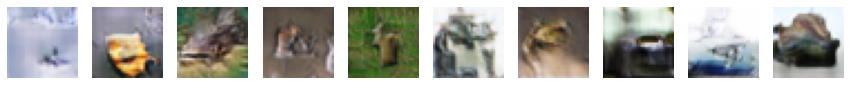

Epoch 18/50
1562/1562 [==============================] - 90s 58ms/step - g_loss: 2.7483 - d_loss: 0.1576


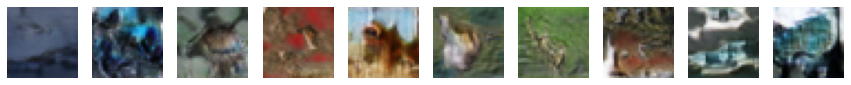

Epoch 19/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 2.7711 - d_loss: 0.1569
Epoch 20/50
1562/1562 [==============================] - 90s 58ms/step - g_loss: 2.8411 - d_loss: 0.1517


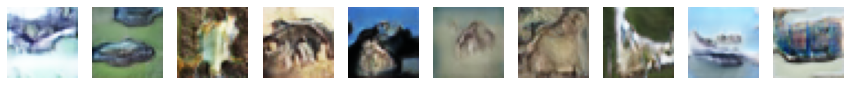

Epoch 21/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 2.8560 - d_loss: 0.1501


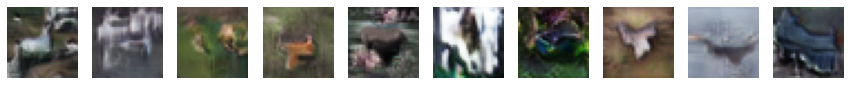

Epoch 22/50
1562/1562 [==============================] - 90s 58ms/step - g_loss: 2.9607 - d_loss: 0.1430
Epoch 23/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 3.0149 - d_loss: 0.1391


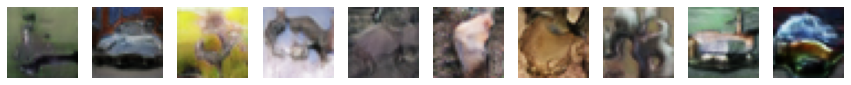

Epoch 24/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 3.0183 - d_loss: 0.1413


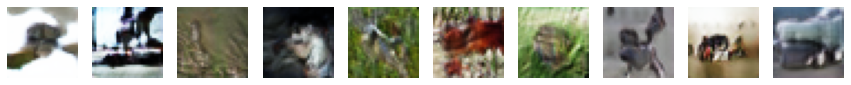

Epoch 25/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 3.0734 - d_loss: 0.1346
Epoch 26/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 3.1871 - d_loss: 0.1314


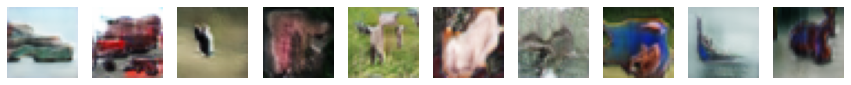

Epoch 27/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 3.1964 - d_loss: 0.1285


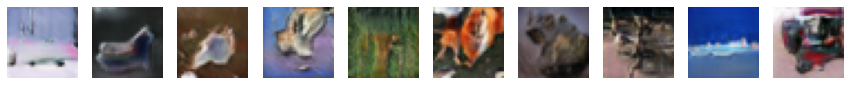

Epoch 28/50
1562/1562 [==============================] - 90s 57ms/step - g_loss: 3.2227 - d_loss: 0.1289
Epoch 29/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 3.3634 - d_loss: 0.1205


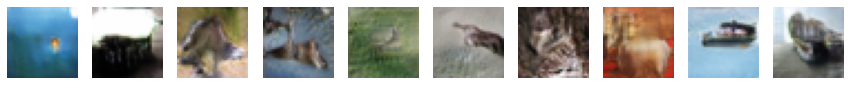

Epoch 30/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 3.3753 - d_loss: 0.1183


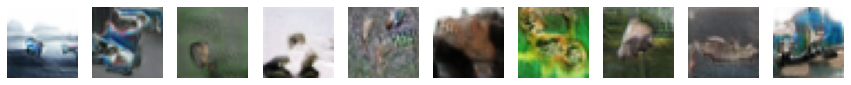

Epoch 31/50
1562/1562 [==============================] - 88s 56ms/step - g_loss: 3.4378 - d_loss: 0.1217
Epoch 32/50
1562/1562 [==============================] - 88s 56ms/step - g_loss: 3.5042 - d_loss: 0.1152


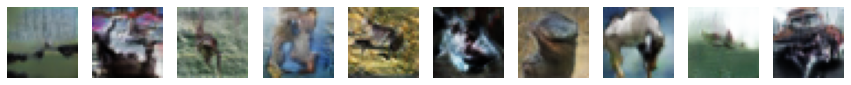

Epoch 33/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 3.5941 - d_loss: 0.1116


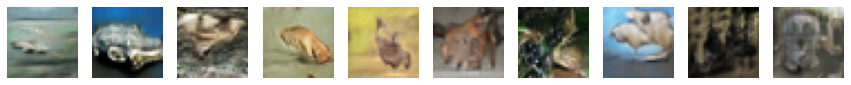

Epoch 34/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 3.6675 - d_loss: 0.1070
Epoch 35/50
1562/1562 [==============================] - 88s 56ms/step - g_loss: 3.6709 - d_loss: 0.1073


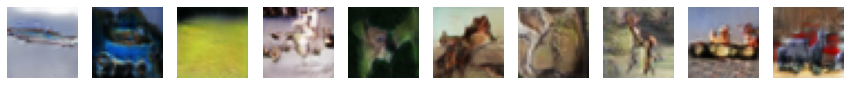

Epoch 36/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 3.6818 - d_loss: 0.1056


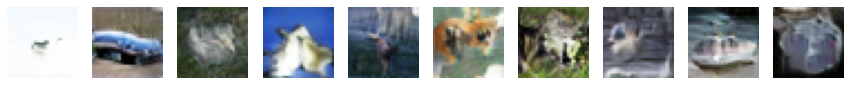

Epoch 37/50
1562/1562 [==============================] - 88s 57ms/step - g_loss: 3.7680 - d_loss: 0.1054
Epoch 38/50
1562/1562 [==============================] - 89s 57ms/step - g_loss: 3.8106 - d_loss: 0.1018


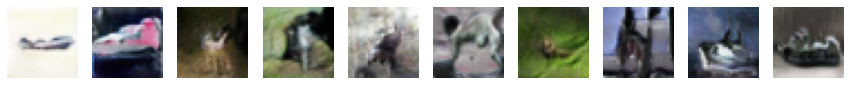

Epoch 39/50
1562/1562 [==============================] - 88s 56ms/step - g_loss: 3.8715 - d_loss: 0.0998


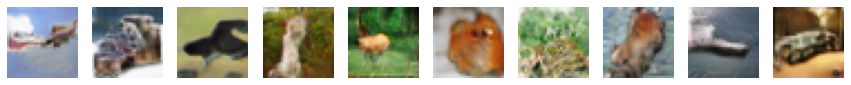

Epoch 40/50
1562/1562 [==============================] - 87s 56ms/step - g_loss: 3.9212 - d_loss: 0.0987
Epoch 41/50
1562/1562 [==============================] - 87s 56ms/step - g_loss: 3.9259 - d_loss: 0.0977


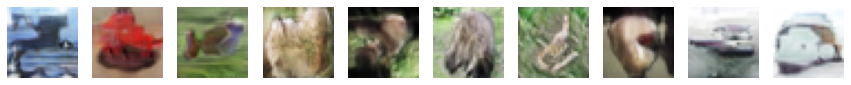

Epoch 42/50
1562/1562 [==============================] - 88s 56ms/step - g_loss: 4.0118 - d_loss: 0.0933


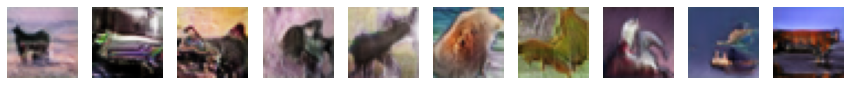

Epoch 43/50
1562/1562 [==============================] - 87s 55ms/step - g_loss: 4.0749 - d_loss: 0.0919
Epoch 44/50
1562/1562 [==============================] - 87s 56ms/step - g_loss: 4.1598 - d_loss: 0.0889


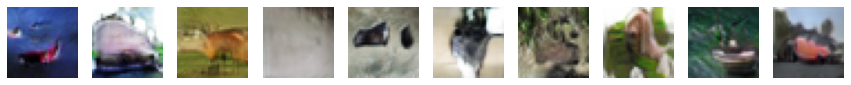

Epoch 45/50
1562/1562 [==============================] - 88s 56ms/step - g_loss: 4.2118 - d_loss: 0.0871


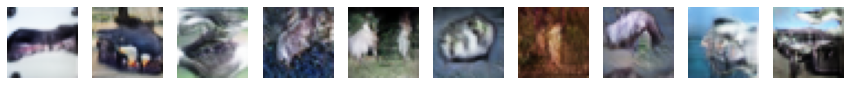

Epoch 46/50
1562/1562 [==============================] - 87s 55ms/step - g_loss: 4.2457 - d_loss: 0.0870
Epoch 47/50
1562/1562 [==============================] - 87s 55ms/step - g_loss: 4.3193 - d_loss: 0.0840


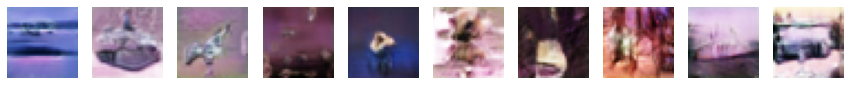

Epoch 48/50
1562/1562 [==============================] - 86s 55ms/step - g_loss: 4.3619 - d_loss: 0.0835


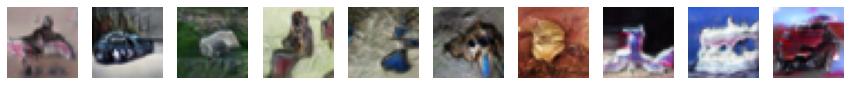

Epoch 49/50
1562/1562 [==============================] - 87s 56ms/step - g_loss: 4.4015 - d_loss: 0.0807
Epoch 50/50
1562/1562 [==============================] - 87s 56ms/step - g_loss: 4.3930 - d_loss: 0.0827


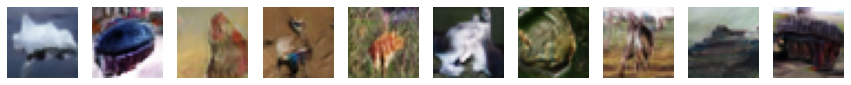

In [15]:
big_gan = BigGAN(10)
big_gan.compile()

callbacks = [GenerativeCallback(interval=3)]

big_gan.fit(train_dataset, epochs=50, callbacks=callbacks)